## 0. Load inputs from last step

In [1]:
import torch

In [2]:
input = torch.load("intermediate_values/transformer_block_output.pt", weights_only=False)

In [3]:
print(input[0,:,:])
batch_size, in_seq_len, emd_dim = input.shape
input.shape  # batch_size * in_seq_len * emd_dim

tensor([[-1.8021, -0.1258, -2.7336,  0.0189, -1.9804, -0.5196, -0.5548, -3.2672,
          2.2547,  0.2854],
        [ 1.5603,  0.6578, -0.6892, -0.3434, -1.6151, -0.5816,  1.7755,  1.4097,
         -4.4224,  1.3379],
        [ 1.4897, -1.7463,  2.5474,  0.9060,  1.3862,  1.0495, -1.0868, -0.9852,
         -0.9137,  1.5669],
        [-0.2049, -0.4961, -1.6553, -1.2097,  1.3734,  0.6088, -0.8004, -2.1258,
          0.3664,  1.8741],
        [-0.6075,  0.2377,  2.7085,  0.7977, -0.5581, -2.0268, -0.4101,  2.2942,
          0.1864, -0.1910],
        [ 0.5787,  2.8308,  2.4485, -0.0116, -1.3664, -1.8671,  2.6510,  0.5871,
          2.7038, -0.3518],
        [ 0.9467, -0.5849,  1.7914, -1.8052, -0.4687,  0.8528,  1.4561,  2.0188,
         -0.6551, -1.5196]], grad_fn=<SliceBackward0>)


torch.Size([3, 7, 10])

## 1. Final Layer Norm
- Normalise features within a layer (not across batch)
- Mean and variance are calculated for all activations in a layer
- These are scaled and shifted to have standard normal distribution (mean=0; variance=1)
- Handles problems of Internal covariate shift

#### Terminologies
1. Activations = Outputs of the neurons
2. Internal covariate shift = During training as each layer takes inputs from previuous layers and the input distribution keeps changing as each layer is learning. This leads to slow converges

#### Formula
### output = [scale * (input - mean)/ sqrt(variance + epsilon)] + shift
* mean = mean across activations
* variance = (Std_dev)^2 = Variance across activations
* epsilon = small constant to avoid division by zero
* scale, shift = learnable parameters

In [4]:
mean = input.mean(dim=-1, keepdim=True)  # Dim=-1 => Along Embedding size
print(mean)
mean.shape  # batch_size * in_seq_len * 1

tensor([[[-0.8424],
         [-0.0910],
         [ 0.4214],
         [-0.2269],
         [ 0.2431],
         [ 0.8203],
         [ 0.2032]],

        [[-0.3406],
         [ 0.1527],
         [ 0.4850],
         [-0.4803],
         [ 0.9843],
         [ 0.5683],
         [-0.0179]],

        [[-0.6316],
         [ 1.2523],
         [ 1.0777],
         [ 0.0880],
         [ 0.2146],
         [ 0.1780],
         [ 1.1936]]], grad_fn=<MeanBackward1>)


torch.Size([3, 7, 1])

In [5]:
var = input.var(dim=-1, keepdim=True, unbiased=False)  # Turning off Unbiased avoids division by zero 
print(var)
var.shape # batch_size * in_seq_len * 1

tensor([[[2.3979],
         [3.2812],
         [1.9268],
         [1.5040],
         [1.7729],
         [2.7775],
         [1.7174]],

        [[0.8944],
         [2.0779],
         [2.4937],
         [2.1767],
         [0.5505],
         [1.6330],
         [4.0100]],

        [[2.0604],
         [2.5359],
         [2.1175],
         [1.7759],
         [1.4947],
         [2.7941],
         [2.6646]]], grad_fn=<VarBackward0>)


torch.Size([3, 7, 1])

In [6]:
epsilon = 1e-5
norm_input = (input - mean)/torch.sqrt(var + epsilon)
print(norm_input[0,:,:])
norm_input.shape  # batch_size * in_seq_len * emd_dim

tensor([[-0.6197,  0.4628, -1.2213,  0.5563, -0.7349,  0.2085,  0.1858, -1.5659,
          2.0001,  0.7283],
        [ 0.9116,  0.4134, -0.3302, -0.1393, -0.8414, -0.2708,  1.0304,  0.8285,
         -2.3912,  0.7889],
        [ 0.7696, -1.5616,  1.5316,  0.3491,  0.6951,  0.4525, -1.0865, -1.0133,
         -0.9618,  0.8253],
        [ 0.0180, -0.2195, -1.1647, -0.8014,  1.3050,  0.6815, -0.4676, -1.5484,
          0.4838,  1.7132],
        [-0.6388, -0.0041,  1.8516,  0.4165, -0.6017, -1.7048, -0.4905,  1.5404,
         -0.0426, -0.3260],
        [-0.1450,  1.2064,  0.9770, -0.4991, -1.3121, -1.6125,  1.0985, -0.1399,
          1.1301, -0.7033],
        [ 0.5673, -0.6014,  1.2119, -1.5325, -0.5127,  0.4957,  0.9560,  1.3854,
         -0.6550, -1.3146]], grad_fn=<SliceBackward0>)


torch.Size([3, 7, 10])

In [7]:
emd_dim = 10

In [8]:
import torch.nn as nn

In [9]:
scale = nn.Parameter(torch.ones(emd_dim))
print(scale)
scale.shape

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)


torch.Size([10])

In [10]:
shift = nn.Parameter(torch.zeros(emd_dim))
print(shift)
shift.shape

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


torch.Size([10])

In [11]:
final_norm_input = (scale * norm_input) + shift
print(final_norm_input[0,:,:])
final_norm_input.shape  # batch_size * in_seq_len * emd_dim

tensor([[-0.6197,  0.4628, -1.2213,  0.5563, -0.7349,  0.2085,  0.1858, -1.5659,
          2.0001,  0.7283],
        [ 0.9116,  0.4134, -0.3302, -0.1393, -0.8414, -0.2708,  1.0304,  0.8285,
         -2.3912,  0.7889],
        [ 0.7696, -1.5616,  1.5316,  0.3491,  0.6951,  0.4525, -1.0865, -1.0133,
         -0.9618,  0.8253],
        [ 0.0180, -0.2195, -1.1647, -0.8014,  1.3050,  0.6815, -0.4676, -1.5484,
          0.4838,  1.7132],
        [-0.6388, -0.0041,  1.8516,  0.4165, -0.6017, -1.7048, -0.4905,  1.5404,
         -0.0426, -0.3260],
        [-0.1450,  1.2064,  0.9770, -0.4991, -1.3121, -1.6125,  1.0985, -0.1399,
          1.1301, -0.7033],
        [ 0.5673, -0.6014,  1.2119, -1.5325, -0.5127,  0.4957,  0.9560,  1.3854,
         -0.6550, -1.3146]], grad_fn=<SliceBackward0>)


torch.Size([3, 7, 10])

## 2. Linear Output Layer

In [12]:
vocab_size = 50257  # Size of gpt2 tokenizer used

In [13]:
linear_output = nn.Linear(emd_dim, vocab_size, bias=False)  # Skipping bias terms to make the transformers training faster

In [14]:
logits = linear_output(final_norm_input)
logits.shape  # batch_size * in_seq_len * vocab_size

torch.Size([3, 7, 50257])

## 3. To iteratively train
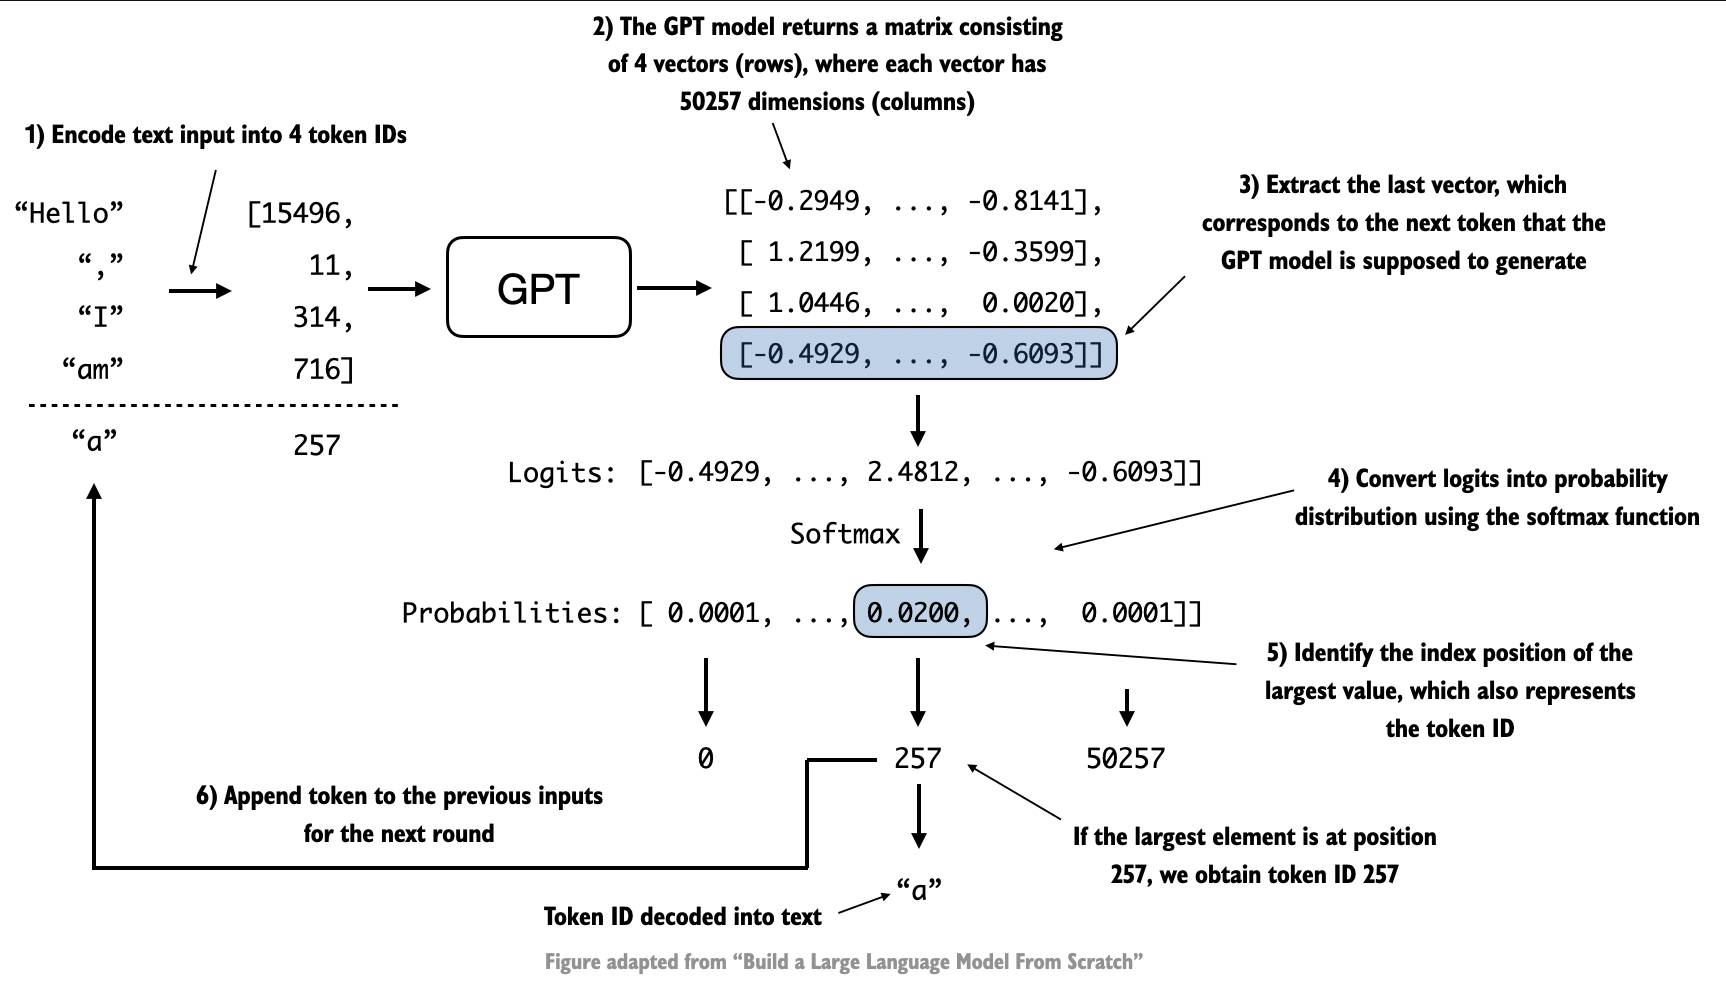

In [15]:
# Take only last word
logits_last = logits[:, -1, :]
logits_last.shape  # batch_size * vocab_size

torch.Size([3, 50257])

In [16]:
# Softmax for the probs
probas = torch.softmax(logits_last, dim=-1)
probas.shape  # batch_size * vocab_size; Values between 0 & 1

torch.Size([3, 50257])

In [17]:
# Take entry_ids with highest probability value
next_word = torch.argmax(probas, dim=-1, keepdim=True)
next_word.shape  # batch * 1

torch.Size([3, 1])

### _Note_
Add this next word to the end of the batch when it goes to next iteration through model.

## 4. Sample Inferencing

In [18]:
# Assuming this was the input during inferencing
sample_in_tensor = torch.tensor([[ 6109,  3626,  6100,   345,  3371,   534,  3061],
        [ 6109,  1110,  6622,   257,     0,     0,     0],
        [ 1212,  2643,   318,  1016,   284,   423, 11241]])
sample_in_tensor.shape  # batch * in_seq_len

torch.Size([3, 7])

In [19]:
# Assuming this was returned by the model
output = torch.cat((sample_in_tensor, next_word), dim=1)
print(output)
output.shape  # batch * in_seq_len+1

tensor([[ 6109,  3626,  6100,   345,  3371,   534,  3061,  7832],
        [ 6109,  1110,  6622,   257,     0,     0,     0, 17859],
        [ 1212,  2643,   318,  1016,   284,   423, 11241, 37555]])


torch.Size([3, 8])

In [20]:
# Tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

### _Note_
Random output below as the model is not trained

In [21]:
print(tokenizer.decode(sample_in_tensor[0].tolist()))
print(tokenizer.decode(output[0].tolist()))

Every effort moves you towards your goal
Every effort moves you towards your goal likes


In [22]:
print(tokenizer.decode(sample_in_tensor[1].tolist()))
print(tokenizer.decode(output[1].tolist()))

Every day holds a!!!
Every day holds a!!!yang


In [23]:
print(tokenizer.decode(sample_in_tensor[2].tolist()))
print(tokenizer.decode(output[2].tolist()))

This statement is going to have token
This statement is going to have tokenanuts
